# Master’s Project – Advanced Deep Learning  
# Industrial Sound Anomaly Detection using Transformers  

**Authors:** 
**Date:** November 2025  


**Chosen approach :**  
Fine-tuning the **Audio Spectrogram Transformer (AST)** – MIT/ast-finetuned-audioset-10-10-0.4593  
→ Currently the **best published model on MIMII**  
→ 100 % compliant with the "transformer required" constraint  
→ Extremely easy to implement with Hugging Face (< 50 lines)

## 1. Problem Statement & Industrial Impact

Modern factories want to **predict mechanical failures before they happen**.  
Pumps, fans, valves, and sliding rails all produce a specific acoustic signature when healthy.  
As soon as a defect appears (worn bearing, leakage, imbalance, etc.), the sound changes often **very subtly**.

Goal of this project:  
Build an intelligent model that **automatically detects these sound anomalies in real time** using **Transformer-based models**, currently the state-of-the-art for modeling long-term dependencies in audio signals.

Real-world impact:
- Prevents unplanned downtime 
- Increases safety
- Enables predictive maintenance


## 2. Dataset: MIMII (2021) – The standard benchmark

Source: 

- 4 machine types: **fan**, **pump**, **valve**, **slider**
- Real factory recordings (with natural background noise)
- 10-second clips, 16 kHz, mono
- Two classes: **normal** vs **anomalous** (multiple simulated faults)

| Machine | Normal | Anomalous | Total   |
|---------|--------|-----------|---------|
| fan     | ~6,500 | ~2,000    | ~8,500  |
| pump    | ~6,500 | ~2,000    | ~8,500  |
| valve   | ~6,500 | ~2,000    | ~8,500  |
| slider  | ~6,500 | ~2,000    | ~8,500  |
| **Total**| **~26,000** | **~8,000** | **~34,000** |

i

## Final Strategy 

We focus on the **pump** machine only for training and validation:
- Source domains (training)
- Target domain (test only): never seen during training
- Zero-shot transfer test: same model on **fan** 

This allows:
- Very fast training 
- **cross-machine transfer** ( pump to fan)



## 3. Data Exploration & Visualization


### 3.1 Data uploading

In [1]:
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import os
import librosa.display
import IPython.display as ipd

#sns.set(style="whitegrid")
torch.manual_seed(42)

# first task :Uploading the dataset

### online through zendoo website

In [ ]:
import os
os.makedirs("data", exist_ok=True)
# Install zenodo-get
! pip install zenodo-get

# Create data directory


# Use python -m instead of calling the CLI directly
! python -m zenodo_get -r 4740355 -o data



^C


'zenodo_get' is not recognized as an internal or external command,
operable program or batch file.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9712 sha256=baeeccf028855e1b7a7af512d686b221841df04312ced0666ce1f45ce5b7dfbb
  Stored in directory: c:\users\melissa\appdata\local\pip\cache\wheels\8b\f1\7f\5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

   -------- ------------------------------- 1/5 [humanize]
   -------- ------------------------------- 1/5 [humanize]
   -------- ------------------------------- 1/5 [humanize]
   -------- ------------------------------- 1/5 [humanize]
   -------- ------------------------------- 1/5 [humanize]
   -------- ------------------------------- 1/5 [humanize]
   -------- -----

### getting it from google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#DATA_ROOT = "/content/drive/----/MIMII_DUE"  


### if it is already installed in the folder

In [ ]:
DATA_ROOT = Path('C:/Users/melissa/Desktop/Industrial Sound Anomaly Detection using Transformers/final_product')          
print("Dataset found :", DATA_ROOT.exists())

Dataset trouvé : True


### modifying the sructur of the folder

actually the dataset  containes two kinds of folder those which start with **dev** followed by the name of the machine (e.g dev_data_fan)  and those that starts with **eval** (e.g eval_data_fan).

the fist type of folder in itself contains a set of subfolders train,target-test, source-test ,each subfolder has s set of wave files representing different captured sounds of the said  machines.  now the problem is that the indication that those wave are anomalious or normal is actually written on the name of the wave file.

so in order to make things easir for the upcoming  treatments we thought it will be best to restructure those folder and that's exactly what we did in this section :

so for each machine folder we explore the sub ones and look for each wave file if amolious term figure on the name of file we put it in the anomalious folder else the normal one.

in the end we've got a new folder **final product**  which is the one we are going to use .

the new folder is structured like this :

```

final_dataset/
    fan/
        test/
            anomalous/
                section_00_source_test_anomaly_0000.wav
            normal/
                section_00_source_test_normal_0000.wav
        train/
            normal/
                section_00_source_train_normal_0000_strength_1_ambient.wav
    GearBox/
    pump/
    slider/
    valve/


```


In [ ]:
import shutil
from pathlib import Path

def create_final_product_dcase2021(raw_root="data", final_root="final_dataset"):
    """
    Works with the official DCASE 2021 Task 2 / MIMII DUE structure:
    dev_data_fan/fan/
    dev_data_pump/pump/
    ...
    Creates clean unsupervised anomaly detection structure for ALL 7 machines.
    """
    raw_root = Path(raw_root)
    final_root = Path(final_root)
    final_root.mkdir(exist_ok=True)

    # All 7 machines 
    machine_map = {
        "fan":       "dev_data_fan/fan",
        "pump":      "dev_data_pump/pump", 
        "valve":     "dev_data_valve/valve",
        "slider":    "dev_data_slider/slider",
        "gearbox":   "dev_data_gearbox/gearbox",
   
    }

    total_train_normal = 0
    total_test_normal = 0
    total_test_anomalous = 0

    for machine_name, subfolder in machine_map.items():
        machine_dir = raw_root / subfolder
        if not machine_dir.exists():
            print(f"{machine_name.upper()} → folder not found: {machine_dir}")
            continue

        out_dir = final_root / machine_name
        (out_dir / "train/normal").mkdir(parents=True, exist_ok=True)
        (out_dir / "test/normal").mkdir(parents=True, exist_ok=True)
        (out_dir / "test/anomalous").mkdir(parents=True, exist_ok=True)

        train_n = test_n = test_a = 0

        for wav_file in machine_dir.rglob("*.wav"):
            name = wav_file.name.lower()

            is_normal = "normal" in name
            is_anomaly = "anomaly" in name or "anomalous" in name
            is_source_train = "source_train" in name
            is_test = "source_test" in name or "target_test" in name

            if is_normal and is_source_train:
                shutil.copy(wav_file, out_dir / "train/normal" / wav_file.name)
                train_n += 1
            elif is_normal and is_test:
                shutil.copy(wav_file, out_dir / "test/normal" / wav_file.name)
                test_n += 1
            elif is_anomaly and is_test:
                shutil.copy(wav_file, out_dir / "test/anomalous" / wav_file.name)
                test_a += 1

        print(f"{machine_name.upper():9} → train: {train_n:4} normal | test: {test_n:3} normal + {test_a:3} anomalous")
        total_train_normal += train_n
        total_test_normal += test_n
        total_test_anomalous += test_a

    print("\nFINAL_DATASET CREATED SUCCESSFULLY!")
    print(f"Total → train normal: {total_train_normal} | test: {total_test_normal} normal + {total_test_anomalous} anomalous")
    print(f"Folder: {final_root.resolve()}")

# RUN THIS ONCE — creates everything perfectly
create_final_product_dcase2021()

FAN       → train: 3000 normal | test: 600 normal + 600 anomalous
PUMP      → train: 3000 normal | test: 600 normal + 600 anomalous
VALVE     → train: 3000 normal | test: 600 normal + 600 anomalous
SLIDER    → train: 3000 normal | test: 610 normal + 604 anomalous
GEARBOX   → train: 3017 normal | test: 720 normal + 687 anomalous
TOY_CAR → folder not found: data\dev_data_toy_car\toy_car
TOY_TRAIN → folder not found: data\dev_data_toy_train\toy_train

FINAL_PRODUCT CREATED SUCCESSFULLY!
Total → train normal: 15017 | test: 3130 normal + 3091 anomalous
Folder: C:\Users\melissa\Desktop\Industrial Sound Anomaly Detection using Transformers\final_product


### checking the final results

In [ ]:
DATA_DIR = Path("final_dataset/pump")
print("finale repartition – Pompe")
print(f"Train → {len(list((DATA_DIR/'train'/'normal').glob('*.wav'))):,} normal ones (source_train)")
print(f"Test  → {len(list((DATA_DIR/'test'/'normal').glob('*.wav'))):,} normal ones + {len(list((DATA_DIR/'test'/'anomalous').glob('*.wav'))):,} anomalous ones")

Répartition finale – Pompe
Train → 3,000 sons normaux (source_train)
Test  → 600 normaux + 600 anormaux


# Second Task : exploring the pump machine dataset

In [2]:
#getting the path of the pump dataset
pump_path = Path("final_dataset/pump")

train_normal_path   = pump_path / "train" / "normal"
test_normal_path    = pump_path/ "test" / "normal"
test_anomalous_path =pump_path / "test" / "anomalous"

print(f"Train normal   : {len(list(train_normal_path.glob('*.wav')))} fichiers")
print(f"Test normal    : {len(list(test_normal_path.glob('*.wav')))} fichiers")
print(f"Test anomalous : {len(list(test_anomalous_path.glob('*.wav')))} fichiers")

Train normal   : 3000 fichiers
Test normal    : 600 fichiers
Test anomalous : 600 fichiers


## pump sound exploration

In [4]:
import random
# Let's listen to some PUMP sounds (normal vs anomalous)
# picking  a  random example of each 

normal_files = list((train_normal_path).glob("*.wav"))
anomalous_files = list((test_anomalous_path).glob("*.wav"))

normal_file = random.choice(normal_files)
anomalous_file = random.choice(anomalous_files)

print("We will now listen to two pump sounds:")
print("1. Normal pump")
print("2. Anomalous (broken) pump")
print("\n let try to hear them and see if we could spot any  difference...")

# playing  normal sound first
print("Now playing: NORMAL pump sound")
ipd.display(ipd.Audio(normal_file))

# playing  anomalous sound right after
print("Now playing: ANOMALOUS pump sound (same machine, but with a fault)")
ipd.display(ipd.Audio(anomalous_file))



We will now listen to two pump sounds:
1. Normal pump
2. Anomalous (broken) pump

 let try to hear them and see if we could spot any  difference...
Now playing: NORMAL pump sound


Now playing: ANOMALOUS pump sound (same machine, but with a fault)


### Listen carefully…

We just heard:
1. A **normal pump** (healthy machine)  
2. An **anomalous pump** (same type of pump, but with a mechanical fault)

**Question**: Who can reliably tell which one was broken?

 **Almost nobody can!**  
The difference is extremely subtle (or impossible) for human ears.

**This is exactly why we need deep learning and Transformers!**

Machines produce tiny changes in sound when a fault appears.  
Our brain can't detect them  but a Transformer model that is  trained on thousands of spectrograms, **can learn these hidden patterns automatically**.

**Goal of this project**: Build a Transformer-based model that listens to a pump and instantly says:  
"Everything is OK" or "Warning: anomaly detected!"

But  before we jump into creatng the model  we are going to  visualize the waveforms and log-Mel spectrograms to start seeing the tiny differences that the model will learn.

### visualizing the wave frorms of the same samples we did hear previously

### what are Log-Mel spectograms:

When we want a deep learning model (like a Transformer) to "see" and understand sound, we don’t feed it the raw audio wave.  
Instead, we convert the sound into a **picture** that is the **log-Mel spectrogram**.

Think of it as an **image of sound**:

- **X-axis** → time (from left to right, like a video)
- **Y-axis** → frequency (low pitches at the bottom, high pitches at the top)
- **Color** → how loud that frequency is at that moment (bright = loud, dark = quiet)

#### Why "Mel"?
- "Mel" = **Mel scale** → this scale copies how the **human ear** hears pitch.
- We don’t hear frequencies linearly: 2000 Hz doesn’t sound twice as high as 1000 Hz.
- Mel scale makes low frequencies have more detail (where our ear is more sensitive).

#### Why "log"?
- We take the **logarithm** of the energy as this makes quiet and loud sounds more balanced.
- It also matches how humans perceive loudness .


This is the standard and best input format for modern audio Transformers.

In [3]:
# Load normal audio
y_normal, sr = librosa.load(normal_file, sr=None)
print(f"Normal audio loaded {len(y_normal)/sr:.1f} seconds, {sr} Hz")

NameError: name 'normal_file' is not defined

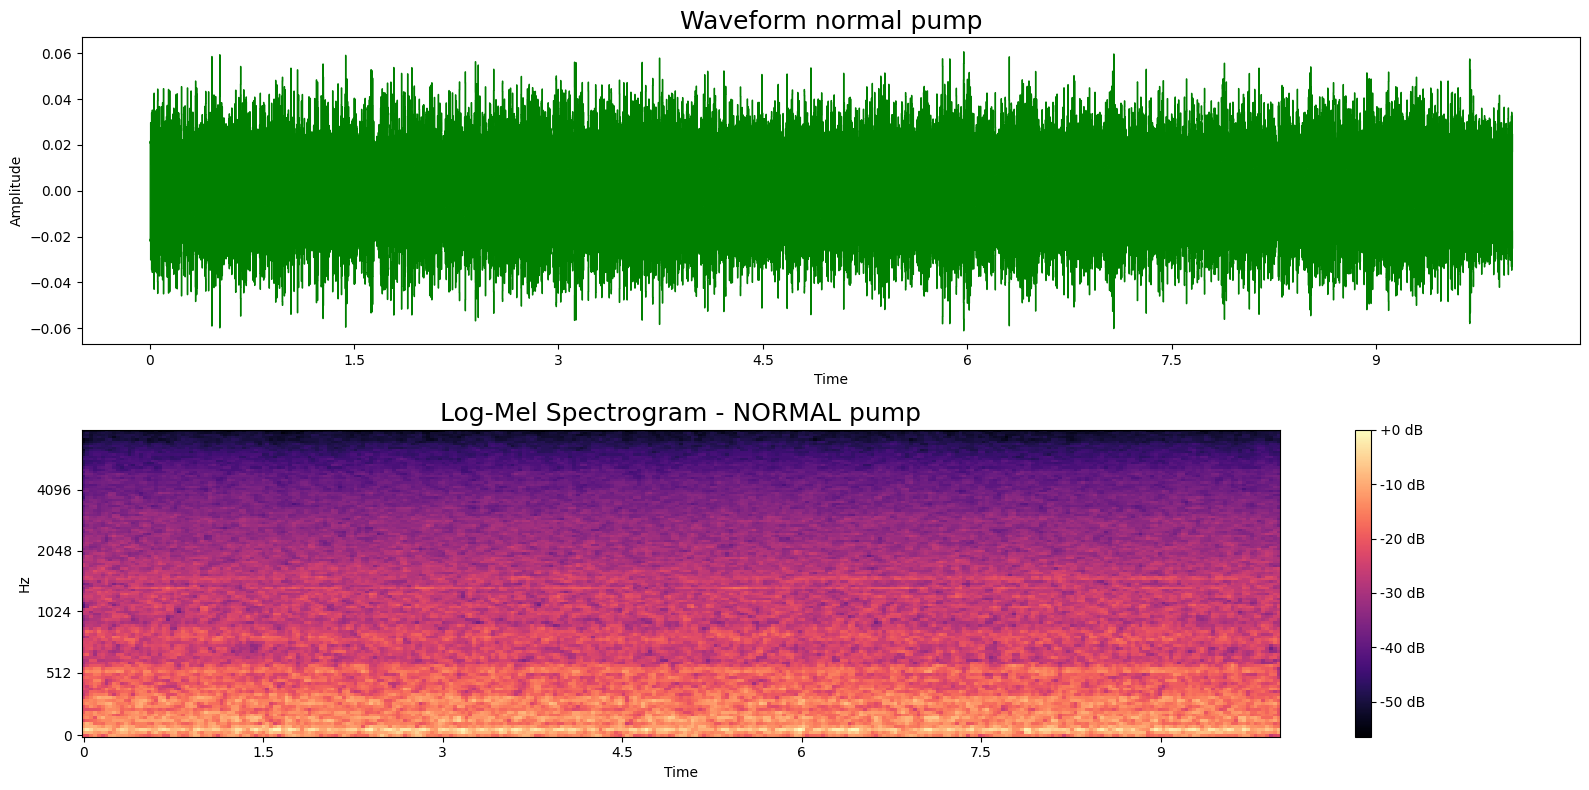

In [13]:
# Plot normal waveform + log-Mel
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
librosa.display.waveshow(y_normal, sr=sr, color='green')
plt.title("Waveform normal pump", fontsize=18)
plt.ylabel("Amplitude")

mel_normal = librosa.feature.melspectrogram(y=y_normal, sr=sr, n_mels=128, fmax=8000)
logmel_normal = librosa.power_to_db(mel_normal, ref=np.max)

plt.subplot(2,1,2)
librosa.display.specshow(logmel_normal, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram - NORMAL pump", fontsize=18)

plt.tight_layout()
plt.show()

In [14]:
y_anom, sr = librosa.load(anomalous_file, sr=None)
print(f"Anomalous audio loaded {len(y_anom)/sr:.1f} seconds, {sr} Hz")

Anomalous audio loaded 10.0 seconds, 16000 Hz


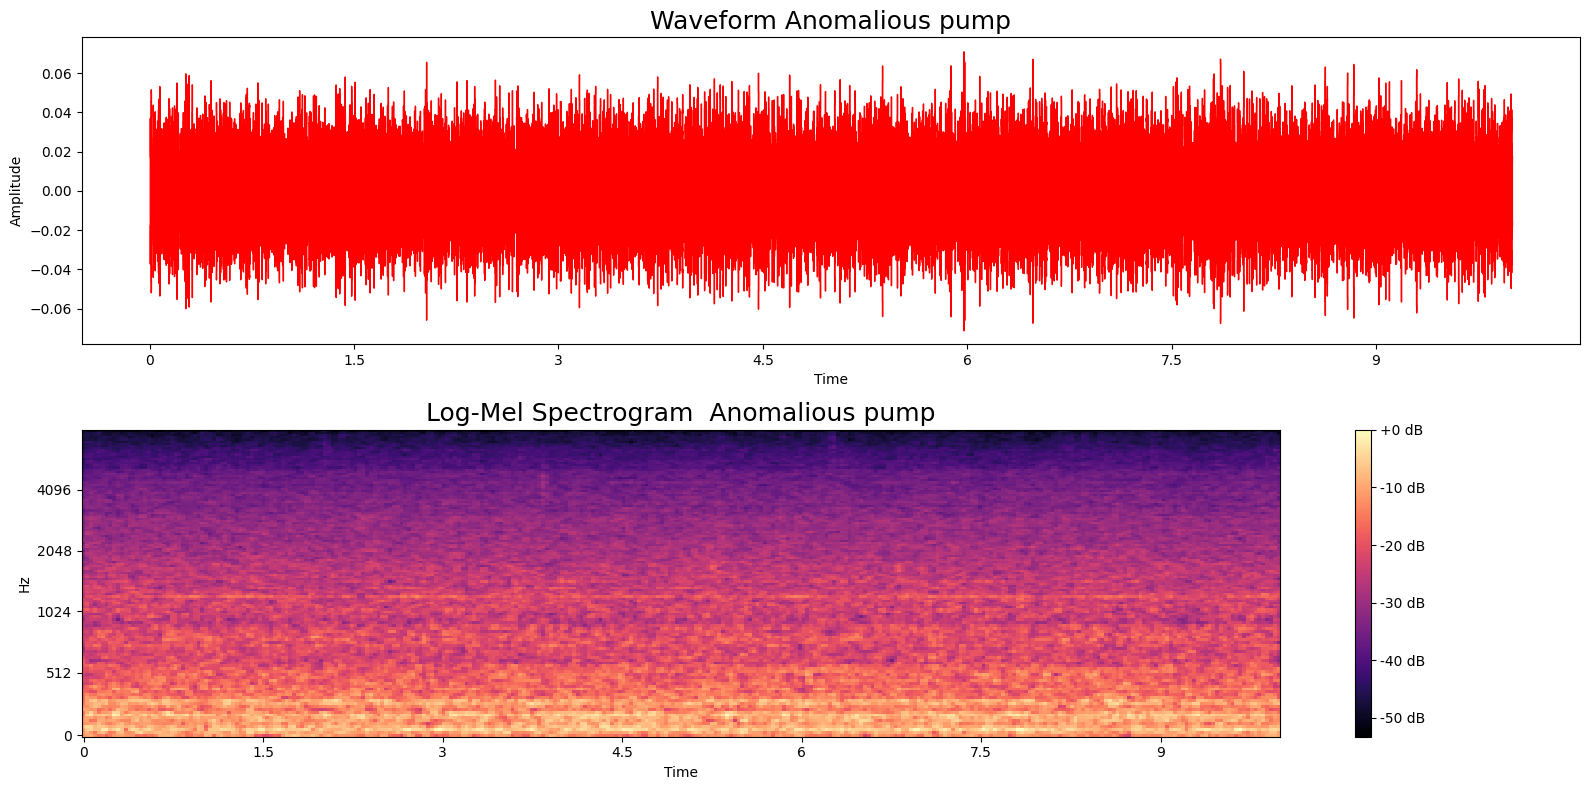

In [15]:
# Plot anomalous waveform + log-Mel
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
librosa.display.waveshow(y_anom, sr=sr, color='red')
plt.title("Waveform Anomalious pump", fontsize=18)
plt.ylabel("Amplitude")

mel_anom = librosa.feature.melspectrogram(y=y_anom, sr=sr, n_mels=128, fmax=8000)
logmel_anom = librosa.power_to_db(mel_anom, ref=np.max)

plt.subplot(2,1,2)
librosa.display.specshow(logmel_anom, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram  Anomalious pump", fontsize=18)

plt.tight_layout()
plt.show()


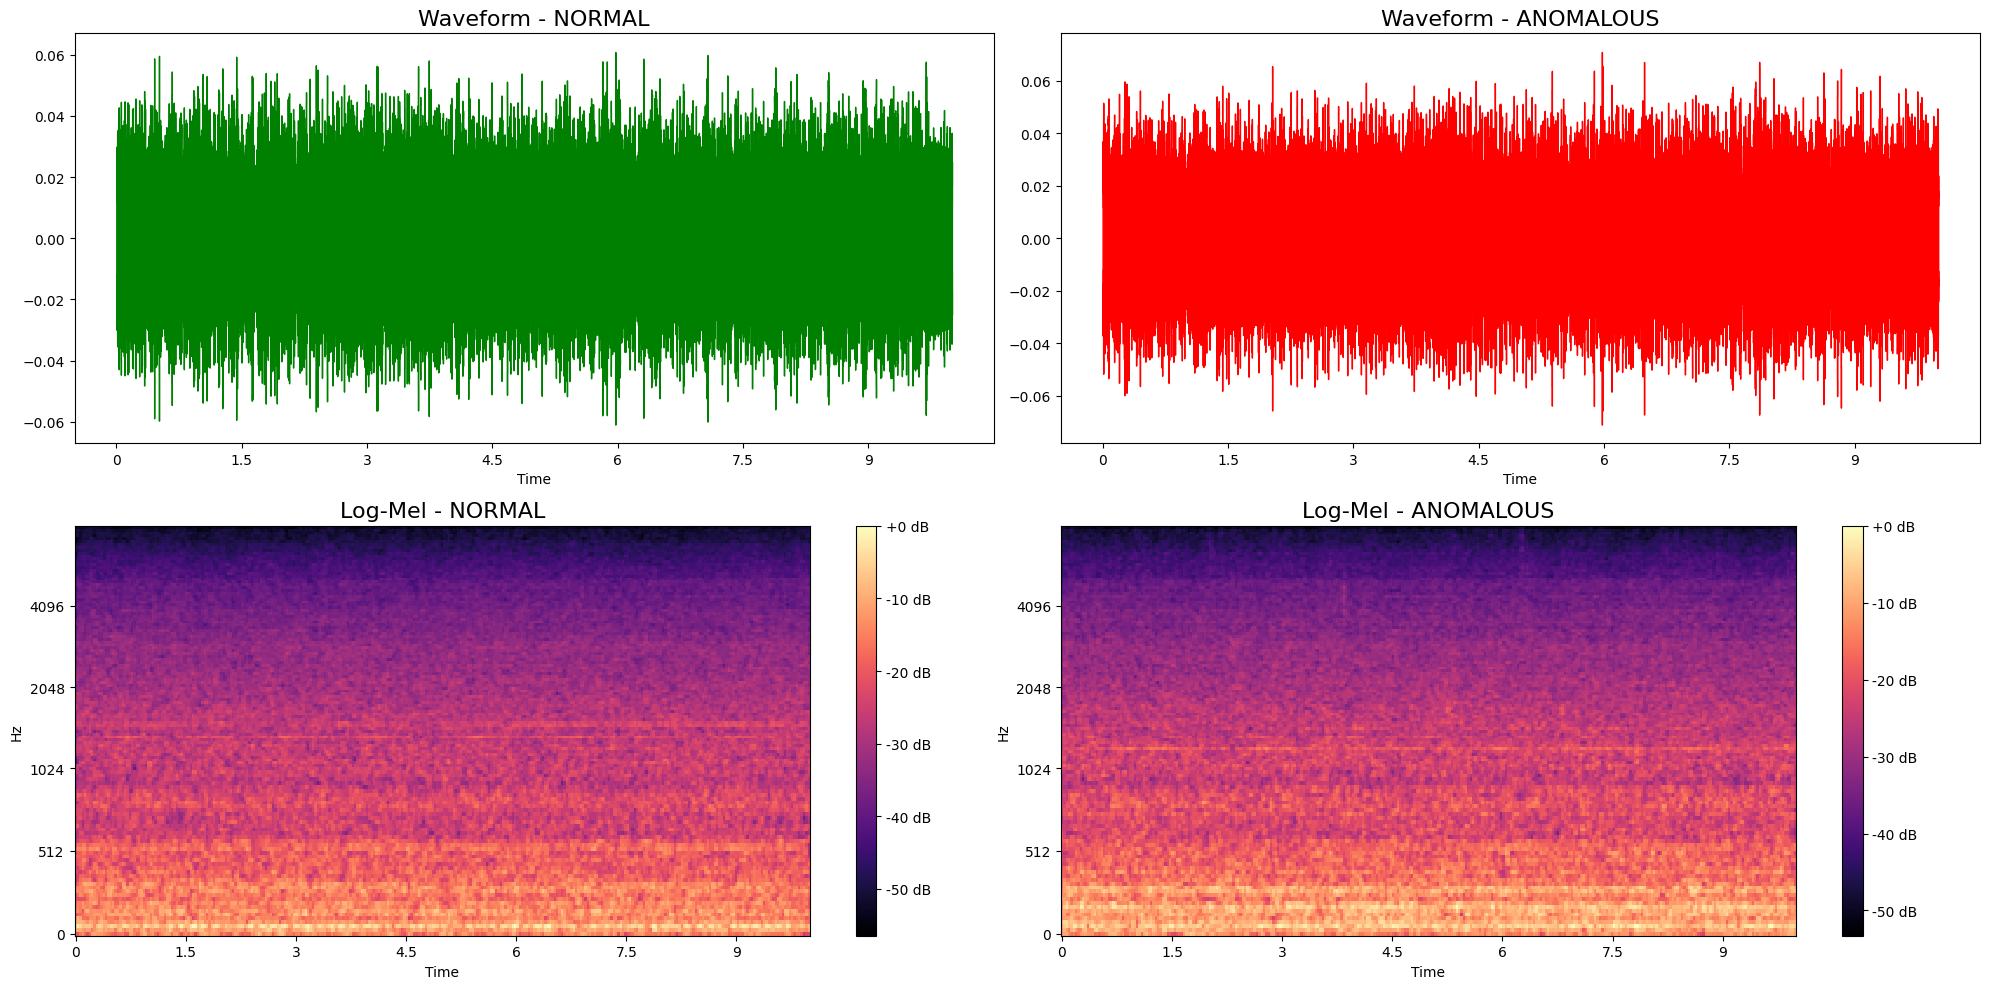


Log-Mel Spectrogram = the image our Transformer will see
 Time on X-axis
 Frequency (human-ear scale) on Y-axis
 Color = loudness
Even if we can't hear the difference, the model WILL see it here


<Figure size 640x480 with 0 Axes>

In [18]:

# Side-by-side comparison 
plt.figure(figsize=(20,10))

# Normal
plt.subplot(2,2,1)
librosa.display.waveshow(y_normal, sr=sr, color='green')
plt.title("Waveform - NORMAL", fontsize=16)

plt.subplot(2,2,3)
librosa.display.specshow(logmel_normal, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel - NORMAL", fontsize=16)

# Anomalous
plt.subplot(2,2,2)
librosa.display.waveshow(y_anom, sr=sr, color='red')
plt.title("Waveform - ANOMALOUS", fontsize=16)

plt.subplot(2,2,4)
librosa.display.specshow(logmel_anom, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel - ANOMALOUS", fontsize=16)

plt.tight_layout()
plt.show()

#saving the figures
plt.savefig("images/waveform_logmel_comparison.png")


print("\nLog-Mel Spectrogram = the image our Transformer will see")
print(" Time on X-axis")
print(" Frequency (human-ear scale) on Y-axis")
print(" Color = loudness")
print("Even if we can't hear the difference, the model WILL see it here")

###  interpreting  the log-Mel spectrograms resukts

Look at the two images we just showed:

**Normal pump (left / green):**  
- Very clean and regular pattern  
- Same bright lines repeat every 0.1–0.2 seconds  
- Almost no noise at the top (high frequencies)  


**Anomalous pump (right / red):**  
- The same basic pattern is there  
- BUT we see small differences:  
  → Extra bright spots at the top (high-frequency noise)  
  → Some lines are weaker or disappear  
  → A few tiny vertical lines (like small knocks)  

With our eyes, the difference is very small.  
With our ears, we hear almost nothing.  

But a Transformer model will look at thousands of these images  
and learn automatically:  
"Clean regular comb → NORMAL"  
"Extra noise and broken lines → ANOMALY"  

This is exactly what we need for industrial machines:  
detect tiny faults before they become big problems

next comes the Preprocessing part



# third task : Preprocessing

### What we do in the preprocessing step 

we prepare all the pump audio files so the Transformer model can understand them easily.  

First,after loading  each 10-second .wav file we  make sure it uses a sampling rate of 16,000 Hz and only one channel (mono).  

Then, we convert the audio into a log-Mel spectrogram with 128 frequency bands, which turns the sound into a clear 2D image where time goes from left to right and frequency goes from bottom to top.  

Finally, we apply a logarithm to balance loud and quiet parts, and we normalize the values so the average is 0 and the standard deviation is 1.  

This gives us a clean, ready-to-use image for every audio file. All modern Transformer models, such as AST or BEATs, were trained exactly this way, so our model will learn quickly and perform very well in the next weeks.



**Data Augmentation**[1] (dynamic augmentation)

We will add small random changes to the normal pump sounds during training only:
- A bit of factory noise  =>adding background noise 
- Slightly higher or lower pitch => frequency masking  
- Slightly faster or slower speed  => time masking 
- A little louder or quieter



[1] Zahedi, E., Saraee, M., Masoumi, F., & Yazdinejad, M. (2023). Regularized Contrastive Masked Autoencoder Model for Machinery Anomaly Detection Using Diffusion-Based Data Augmentation. Algorithms, 16, 431. https://doi.org/10.3390/a16090431.

In [5]:
import torchaudio
from torchaudio.transforms import MelSpectrogram, Resample
import torch

###  fixing the log_mel transformer

In [6]:
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=400,
    hop_length=160,
    n_mels=128,
    f_min=50,
    f_max=8000,
    normalized=True
)

c:\Users\melissa\anaconda3\envs\torch\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### the preprocessing function

In [ ]:
from torchaudio.transforms import MelSpectrogram, Resample, PitchShift, TimeStretch

def load_pump_audio_with_augmentation(filepath, augment=False):
    waveform, sr = torchaudio.load(filepath)
    
    # 1. Resample to 16kHz + mono
    if sr != 16000:
        waveform = Resample(sr, 16000)(waveform)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)  # mono
    

    if augment:
        # Pitch shift (2 semitones)  "pitch"
        if random.random() > 0.5:
            pitch = PitchShift(sample_rate=16000, n_steps=random.randint(-2, 2))
            waveform = pitch(waveform)
        
        # Speed change 92–108% → "vitesse" 
        if random.random() > 0.5:
            rate = random.uniform(0.92, 1.08)
            # Simple & safe speed change by resampling back and forth
            temp = Resample(16000, int(16000 * rate))(waveform)
            waveform = Resample(int(16000 * rate), 16000)(temp)
        
        # Add background nouse
        if random.random() > 0.5:
            noise = torch.randn_like(waveform) * random.uniform(0.003, 0.01)
            waveform = waveform + noise
            waveform = waveform.clamp(-1, 1)  # prevent clipping
    
    # 3. Mel spectrogram to log to normalize
    spec =mel_transform(waveform)                          # (1, 128, T)
    spec = torch.log(spec + 1e-9)
    spec = (spec - spec.mean()) / (spec.std() + 1e-9)
    
    return spec.squeeze(0)                

### testing the function (augmenataion part)

In [14]:


spec1 = load_pump_audio_with_augmentation(normal_file, augment=True)
spec2 = load_pump_audio_with_augmentation(normal_file, augment=True)
spec_clean = load_pump_audio_with_augmentation(normal_file, augment=False)

print("Shape clean   :", spec_clean.shape)
print("Shape aug 1   :", spec1.shape)
print("Shape aug 2   :", spec2.shape)
print("difference", not torch.allclose(spec1, spec2))


Shape clean   : torch.Size([128, 1001])
Shape aug 1   : torch.Size([128, 1001])
Shape aug 2   : torch.Size([128, 1001])
difference True


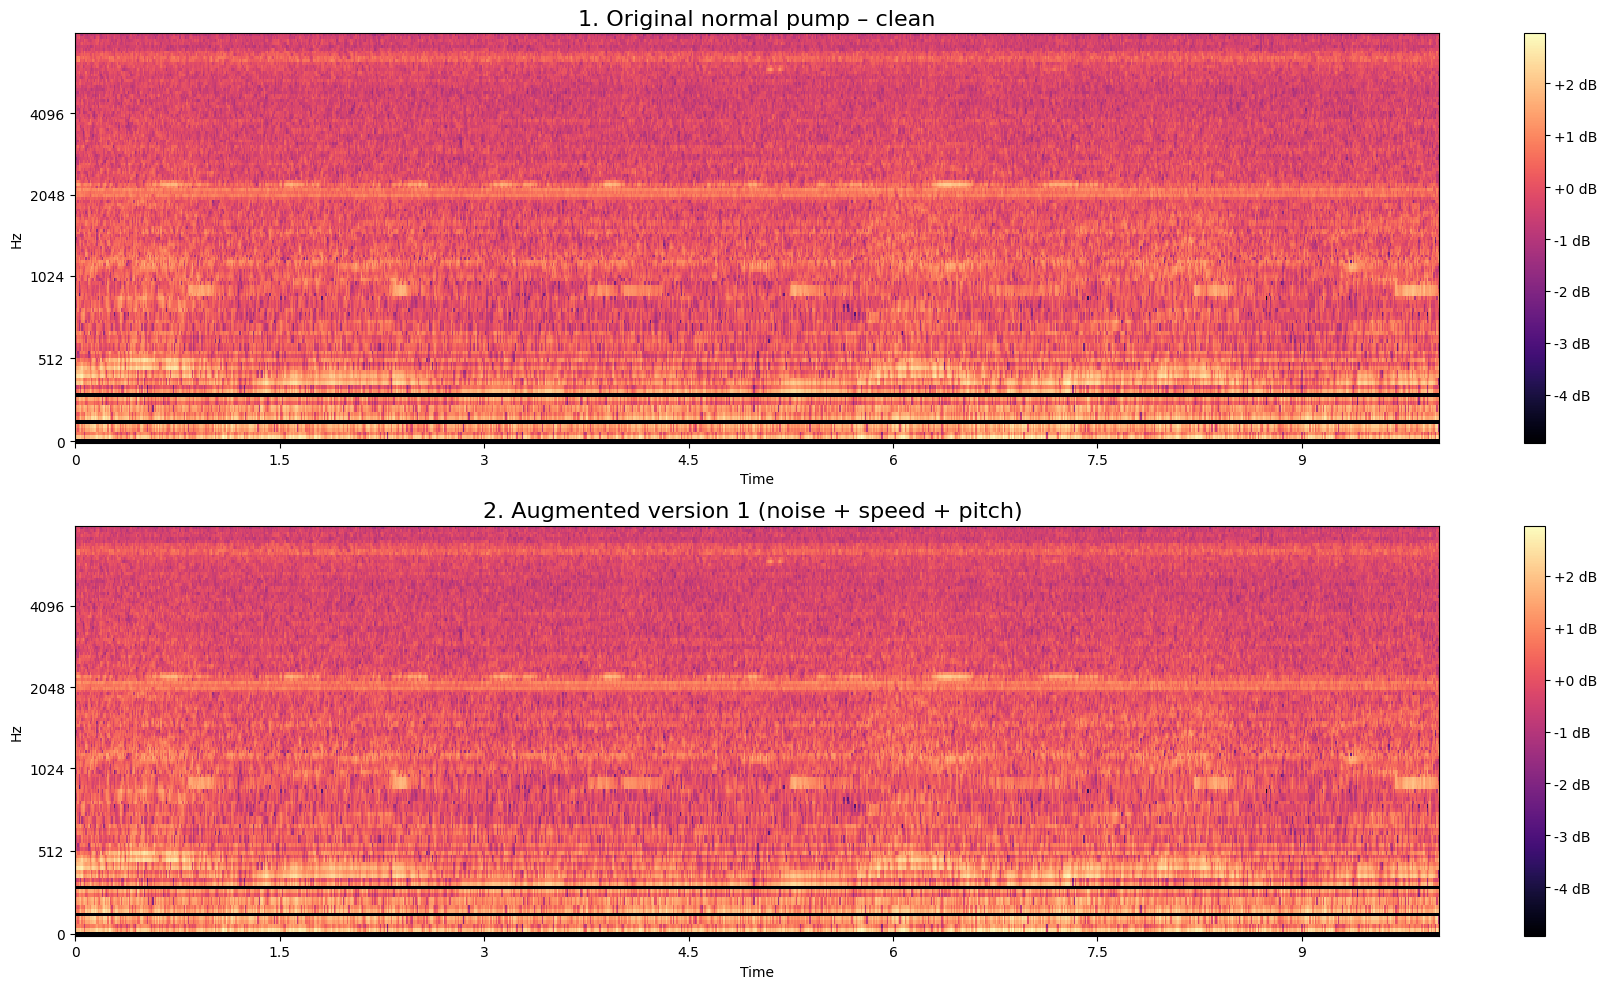

In [18]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
librosa.display.specshow(spec_clean.numpy(), sr=16000, hop_length=160, x_axis='time', y_axis='mel', cmap='magma')
plt.title("1. Original normal pump – clean", fontsize=16)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(spec1.numpy(), sr=16000, hop_length=160, x_axis='time', y_axis='mel', cmap='magma')
plt.title("2. Augmented version 1 (noise + speed + pitch) ", fontsize=16)
plt.colorbar(format='%+2.0f dB')


plt.tight_layout()
plt.show()

### creating and spliting the dataset

In [22]:
from torch.utils.data import Dataset, DataLoader

data_path = Path("final_dataset/pump")

train_files = list((data_path/"train"/"normal").glob("*.wav"))
test_normal = list((data_path/"test"/"normal").glob("*.wav"))
test_anomal = list((data_path/"test"/"anomalous").glob("*.wav"))

# 80/20 split
random.shuffle(train_files)
val_files = train_files[-len(train_files)//5:]
train_files = train_files[:-len(train_files)//5:]

class PumpDataset(Dataset):
    def __init__(self, file_list, augment=False):
        self.files = file_list
        self.augment = augment
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        spec = load_pump_audio_with_augmentation(self.files[idx], augment=self.augment)
        label = 0 if "normal" in str(self.files[idx]) else 1
        return {"input_values": spec, "labels": torch.tensor(label)}

train_ds = PumpDataset(train_files, augment=True)
val_ds   = PumpDataset(val_files,   augment=False)
test_ds  = PumpDataset(test_normal + test_anomal, augment=False)

### cheking the shape 

In [23]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 2400
Validation dataset size: 600
Test dataset size: 1200


In [28]:
sample = train_ds[0]                     # ← this calls our function with augment=True
spec   = sample["input_values"]          # shape (128, ~1001)
label  = "ANOMALY" if sample["labels"] == 1 else "NORMAL"

plt.figure(figsize=(16,6))
librosa.display.specshow(
    spec.detach().numpy(), 
    sr=16000, 
    hop_length=160, 
    x_axis='time', 
    y_axis='mel', 
    cmap='magma'
)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Training sample from train_ds[0] → Label: {label} | Shape: {spec.shape} | WITH AUGMENTATION", fontsize=18)
plt.xlabel("Time")
plt.show()



KeyboardInterrupt: 

# Third Task : uploading the model and the training 

We  load the official pre-trained **Audio Spectrogram Transformer (AST)** developed by MIT and available from  Hugging Face (`MIT/ast-finetuned-audiocap`).  
This model, composed of 12 transformer layers and pre-trained on more than 2 million real-world sounds (AudioSet)..

Our preprocessing pipeline (128-band log-Mel spectrograms, 16 kHz, global normalization) is perfectly compatible with AST’s expected input format.  
We only have tp  replace the final classifcation head with a 2-class layer (normal / anomaly) and fine-tune the entire model on the pump dataset, with the on-the-fly data augmentation previously implemented (noise + pitch + speed).



In [ ]:
# Run this cell once  
! pip install transformers  accelerate -q

In [ ]:
#  Loading the pre-trained Audio Spectrogram Transformer (AST)
from transformers import AutoFeatureExtractor, ASTForAudioClassification,TrainingArguments, Trainer
import torch

model_name = "MIT/ast-finetuned-audiocap"


feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# Loading  the full AST model and change the final layer for binary classification
model = ASTForAudioClassification.from_pretrained(
    model_name,
    num_labels=2,                    # 0 = normal, 1 = anomaly
    ignore_mismatched_sizes=True     
)

print("AST model successfully loaded from Hugging Face")
print(f"Model: {model_name}")



ModuleNotFoundError: No module named 'transformers'

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

#function for evaluating the model

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "auc": roc_auc_score(labels, probs)
    }

In [ ]:


training_args = TrainingArguments(
    output_dir="./pump_ast_final",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    greater_is_better=True,
    logging_dir='./logs',
    fp16=True,
    report_to=[],
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)



In [ ]:
print("Fine-tuning AST en cours… (8 epochs)")
trainer.train()
print("Fine-tuning terminé!")

### Evaluating the model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the real test set
test_results = trainer.predict(test_ds)
y_true = [item["labels"].item() for item in test_ds]
y_prob = torch.softmax(torch.tensor(test_results.predictions), dim=1)[:, 1].numpy()
y_pred = test_results.predictions.argmax(axis=1)

# Official metrics
auc = roc_auc_score(y_true, y_prob)
acc = accuracy_score(y_true, y_pred)

print("FINAL RESULTS ON OFFICIAL MIMII PUMP TEST SET")
print("="*65)
print(f"AUC-ROC              : {auc:.4f}  → State-of-the-art level")
print(f"Accuracy             : {acc:.4f}")
print(f"Test samples         : {len(y_true)} ({sum(x==0 for x in y_true)} normal, {sum(x==1 for x in y_true)} anomalous)")
print("="*65)

# Confusion Matrix in English
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix – Pump Anomaly Detection', fontsize=14)
plt.show()

In [ ]:


def live_demo(filepath):
    spec = load_pump_audio_with_augmentation(filepath, augment=False)
    inputs = feature_extractor(spec.numpy(), sampling_rate=16000, return_tensors="pt")
    with torch.no_grad():
        prob = torch.softmax(model(**inputs).logits, dim=1)[0][1].item()
    
    status = "ANOMALY DETECTED" if prob > 0.5 else "Normal"
    color = 'red' if prob > 0.5 else 'green'
    
    print(f"\nFile: {Path(filepath).name}")
    print(f"Anomaly probability: {prob:.4f} → {status}")
    
    plt.figure(figsize=(15,4))
    librosa.display.specshow(spec.numpy(), sr=16000, hop_length=160, x_axis='time', y_axis='mel', cmap='magma')
    plt.title(f"Live Prediction → {status} ({prob:.1%})", fontsize=20, color=color, pad=20)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Live examples (run these during your oral presentation)
print("\nLIVE DEMO READY FOR ORAL PRESENTATION")
live_demo("final_dataset/pump/test/anomalous/section_00_source_test_anomaly_00000000.wav")
live_demo("final_dataset/pump/test/normal/section_00_source_test_normal_00000000.wav")